In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import openpyxl
import fnmatch
import tensorflow as tf
import random
import datetime

from tensorflow.keras.models import load_model
from tensorflow.python.keras.optimizer_v2.rmsprop import RMSProp
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv, DataFrame, concat
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, RepeatVector, LSTM, Input, TimeDistributed, Activation, Dropout
from keras.optimizers import SGD
from pandas import read_csv
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer 
#from feature_engine import variable_transformers as vt
from scipy.stats import yeojohnson
from keras import backend as K

np.set_printoptions(suppress=True)


seed = 2
random.seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
tf.random.set_seed(seed)


# file
START_DATE = '20200101'
END_DATE   = '20210704'
BASE_PATH = 'C:/elsys/solar/'
SAVE_TOTAL_DIR = BASE_PATH + 'total_csv/'


# data ratio
TRAIN_RATIO  = 0.6
VAL_RATIO    = 0.2

# timesteps
SHIFT_DAYS   = 3
PRED_STEPS   = 24
TIME_STEPS   = SHIFT_DAYS*PRED_STEPS

TARGET_ILOC_STEPS = PRED_STEPS*(SHIFT_DAYS)
#과거 데이터 첫 IDX ~ TARGET과의 STEP 차이

# model param
DIMENSION    = 15
MODEL_NUM    = 1
EPOCHS       = 500
BATCH_SIZE   = 32
EARLY_STOP_PATIENCE = 200

# elsys rsrid
RSRS_IDX = 3
BASE_PATH = 'C:/elsys/solar/'
RSRSID_list=['RSRS0000000239', 'RSRS0000000241', 'RSRS0000000247', 'RSRS0000000249']
RSRS_SAVE_NM = RSRSID_list[RSRS_IDX][11:14]
CAPACITY_list = [89.7, 96.6, 90, 46.2]
CAPACITY     = float(CAPACITY_list[RSRS_IDX])
print("CAPACITY:",CAPACITY)

NOWDATE = str(datetime.datetime.now()).replace("-", "").replace(":", "").replace(" ", "_").replace(".", "_")
SAVE_PATH = BASE_PATH+'data/'+str(NOWDATE)+'/'
os.mkdir(SAVE_PATH)

FILE_SEED = NOWDATE[-6:]
SAVE_NAME = str(FILE_SEED)+'_1h_'+str(EPOCHS)+'e_'+str(BATCH_SIZE)+'b'
print("SAVE_PATH:", SAVE_PATH)
print("SAVE_NAME:", SAVE_NAME)

#df = read_csv(SAVE_TOTAL_DIR + '239_dataset0_20200101_20210704_ASOS.csv', index_col='DATE', encoding='CP949')#, converters={'hour':str})#
df = read_csv(SAVE_TOTAL_DIR + '249_dataset0_20200101_20210704_ASOS.csv', encoding='CP949')#, converters={'hour':str})
#df = df[10:]
display(df)


CAPACITY: 46.2
SAVE_PATH: C:/elsys/solar/data/20210723_062246_630512/
SAVE_NAME: 630512_1h_500e_32b


,DATE,POWER,강수량(mm),풍속(m/s),습도(%),현지기압(hPa),일조(hr),전운량(10분위),시정(10m),지면온도(°C)
0,2020010100,0.0,NaN,4.4,54.0,1011.6,NaN,0.0,1926.0,-5.0
1,2020010101,0.0,NaN,4.4,51.0,1011.7,NaN,0.0,1972.0,-5.2
2,2020010102,0.0,NaN,4.4,45.0,1010.9,NaN,0.0,1957.0,-5.3
3,2020010103,0.0,NaN,4.8,47.0,1011.4,NaN,0.0,1985.0,-5.3
4,2020010104,0.0,NaN,3.3,49.0,1011.3,NaN,0.0,1991.0,-4.8
...,...,...,...,...,...,...,...,...,...,...
13218,2021070419,0.0,NaN,1.9,86.0,989.5,0.0,10.0,1991.0,22.4
13219,2021070420,0.0,NaN,0.3,87.0,989.6,0.0,10.0,1870.0,21.8
13220,2021070421,0.0,NaN,0.2,92.0,990.5,NaN,10.0,1647.0,21.4
13221,2021070422,0.0,NaN,0.1,95.0,990.9,NaN,10.0,1539.0,20.7


In [2]:

## # sin ( 시간 ) 변환
def transHour(df):
    df = read_csv(SAVE_TOTAL_DIR + '249_dataset0_20200101_20210704_ASOS.csv', encoding='CP949')#, converters={'hour':str})
    #df = df[10:]
    features_selected = ['DATE', 'POWER', 'solarradiation', 'humidity', 'windspeed', 'temp', 'winddir']
    df = df[features_selected]
    display(df)

    df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d%H')
    df.index = df['DATE']
    #df['DATE'] = df['DATE'].dt.strftime('%H')
    #df = df.rename(columns={'DATE': 'hour'})

    date_time = pd.to_datetime(df.pop('DATE'), format='%Y%m%d%H')
    timestamp_s = date_time.map(datetime.datetime.timestamp)
    print("timestamp_s:", timestamp_s)

    day = 24*60*60
    #year = (365.2425)*day

    df['sin_date'] = np.sin(timestamp_s * (2 * np.pi / day))

    plt.plot(np.array(df['sin_date'])[:50])
    #plt.plot(np.array(df['Day cos'])[:25])
    plt.xlabel('Time [h]')
    plt.title('Time of day signal')

    display(df)
    return df

## # 풍향과 속도 열을 바람 벡터로 변환
def transWind(df):
    print(df.columns)
    df['winddir'].fillna(0)
    df['windspeed'].fillna(0)

    plt.hist2d(df['winddir'].dropna().values, df['windspeed'].dropna().values, bins=(50, 50), vmax=400)
    plt.colorbar()
    plt.xlabel('Wind Direction [deg]')
    plt.ylabel('Wind Speed [m/s]')

    wv = df.pop('windspeed')

    # Convert to radians.
    wd_rad = df.pop('winddir')*np.pi / 180

    # Calculate the wind x and y components.
    df['wind_x'] = wv*np.cos(wd_rad)
    df['wind_y'] = wv*np.sin(wd_rad)

    plt.hist2d(df['wind_x'].dropna().values, df['wind_y'].dropna().values, bins=(50, 50), vmax=400)
    plt.colorbar()
    plt.xlabel('Wind X [m/s]')
    plt.ylabel('Wind Y [m/s]')
    ax = plt.gca()
    ax.axis('tight')
    return df


#df = transHour(df)
#df = transWind(df)
df['습도(%)'] = df['습도(%)']*(-1)
#df_weather.drop(['POWER'], axis=1, inplace=True)
display(df.corr())

df.drop(['DATE','전운량(10분위)'], axis=1, inplace=True)
#features_selected = ['POWER', 'hour', 'solarradiation', 'humidity', 'windspeed', 'temp', 'winddir']
#features_selected = ['POWER', 'solarradiation', 'humidity', 'windspeed','sin_date']
#df = df[features_selected]
display(df.head(3))

,DATE,POWER,강수량(mm),풍속(m/s),습도(%),현지기압(hPa),일조(hr),전운량(10분위),시정(10m),지면온도(°C)
DATE,1.000000,0.047151,-0.024074,0.009779,0.067933,-0.022615,0.039472,0.033305,0.147541,-0.074395
POWER,0.047151,1.000000,-0.084676,0.405859,0.569398,0.048126,0.649131,-0.213505,0.322970,0.372393
강수량(mm),-0.024074,-0.084676,1.000000,0.147105,-0.180764,-0.129584,-0.086260,0.108957,-0.231758,0.051679
풍속(m/s),0.009779,0.405859,0.147105,1.000000,0.577089,0.012989,0.402475,-0.126776,0.412312,0.040250
습도(%),0.067933,0.569398,-0.180764,0.577089,1.000000,0.299969,0.679184,-0.336713,0.651518,0.066972
현지기압(hPa),-0.022615,0.048126,-0.129584,0.012989,0.299969,1.000000,0.271034,-0.259628,0.199398,-0.634897
일조(hr),0.039472,0.649131,-0.086260,0.402475,0.679184,0.271034,1.000000,-0.647950,0.404026,0.177046
전운량(10분위),0.033305,-0.213505,0.108957,-0.126776,-0.336713,-0.259628,-0.647950,1.000000,-0.186269,0.108109
시정(10m),0.147541,0.322970,-0.231758,0.412312,0.651518,0.199398,0.404026,-0.186269,1.000000,0.026996
지면온도(°C),-0.074395,0.372393,0.051679,0.040250,0.066972,-0.634897,0.177046,0.108109,0.026996,1.000000


,POWER,강수량(mm),풍속(m/s),습도(%),현지기압(hPa),일조(hr),시정(10m),지면온도(°C)
0,0.0,NaN,4.4,-54.0,1011.6,NaN,1926.0,-5.0
1,0.0,NaN,4.4,-51.0,1011.7,NaN,1972.0,-5.2
2,0.0,NaN,4.4,-45.0,1010.9,NaN,1957.0,-5.3


,count,mean,std,min,25%,50%,75%,max
POWER,13199.0,5.771877,8.987212,0.0,0.0,0.0,9.0,147.0
강수량(mm),1316.0,1.837538,3.683465,0.0,0.1,0.5,2.0,48.2
풍속(m/s),13205.0,2.074676,1.716078,0.0,0.5,1.8,3.3,9.8
습도(%),13205.0,-72.853768,22.299198,-100.0,-94.0,-76.0,-57.0,-11.0
현지기압(hPa),13166.0,996.266702,7.574265,959.8,990.7,996.5,1002.1,1014.5
일조(hr),7271.0,0.449704,0.446598,0.0,0.0,0.3,1.0,1.0
시정(10m),13180.0,1216.709484,611.356098,1.0,690.0,1300.0,1821.0,2180.0
지면온도(°C),13203.0,13.464932,11.043994,-7.0,3.8,12.9,21.7,51.5


,POWER,강수량(mm),풍속(m/s),습도(%),현지기압(hPa),일조(hr),시정(10m),지면온도(°C)
POWER,1.000000,-0.084676,0.405859,0.569398,0.048126,0.649131,0.322970,0.372393
강수량(mm),-0.084676,1.000000,0.147105,-0.180764,-0.129584,-0.086260,-0.231758,0.051679
풍속(m/s),0.405859,0.147105,1.000000,0.577089,0.012989,0.402475,0.412312,0.040250
습도(%),0.569398,-0.180764,0.577089,1.000000,0.299969,0.679184,0.651518,0.066972
현지기압(hPa),0.048126,-0.129584,0.012989,0.299969,1.000000,0.271034,0.199398,-0.634897
일조(hr),0.649131,-0.086260,0.402475,0.679184,0.271034,1.000000,0.404026,0.177046
시정(10m),0.322970,-0.231758,0.412312,0.651518,0.199398,0.404026,1.000000,0.026996
지면온도(°C),0.372393,0.051679,0.040250,0.066972,-0.634897,0.177046,0.026996,1.000000


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

c:\users\vislab_phy\anaconda3\envs\py_38_shap\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\vislab_phy\anaconda3\envs\py_38_shap\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\vislab_phy\anaconda3\envs\py_38_shap\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\vislab_phy\anaconda3\envs\py_38_shap\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54413 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\vislab_phy\anaconda3\envs\py_38_shap\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49549 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\vislab_phy\

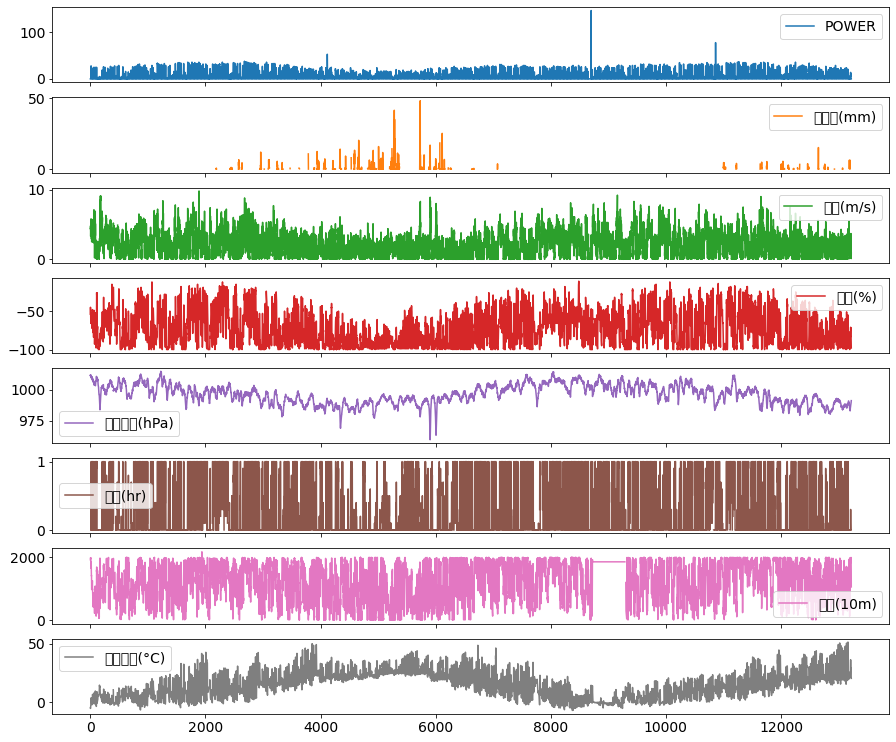

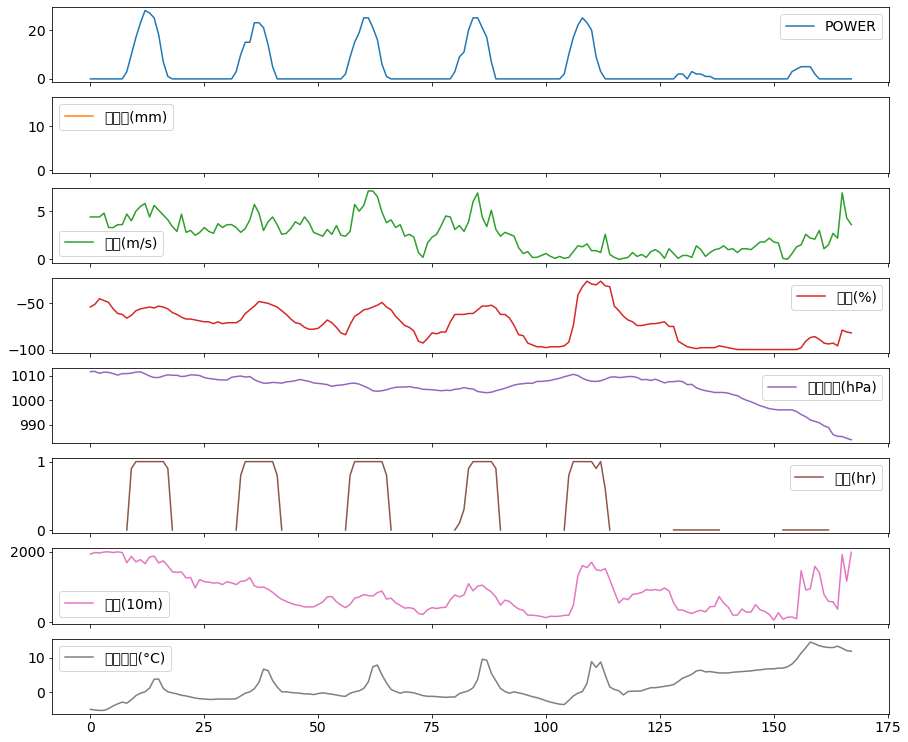

In [3]:
plt.rcParams.update({'font.size': 14})

display(df.describe().transpose())
display(df.corr())
df.plot(subplots=True, figsize=(15,13), fontsize=14)
df[0:24*7].plot(subplots=True, figsize=(15,13))



c:\users\vislab_phy\anaconda3\envs\py_38_shap\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\vislab_phy\anaconda3\envs\py_38_shap\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\vislab_phy\anaconda3\envs\py_38_shap\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\vislab_phy\anaconda3\envs\py_38_shap\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54413 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\vislab_phy\anaconda3\envs\py_38_shap\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49549 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\vislab_phy\

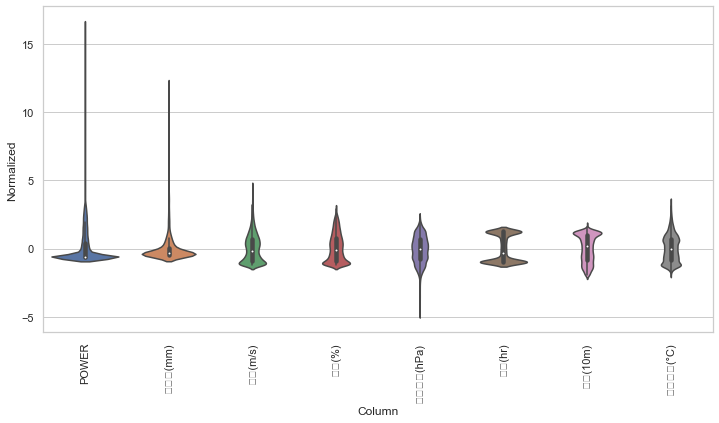

In [4]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

# Normalization 
# 모델이 검증 및 테스트 세트의 값에 액세스할 수 없도록 훈련 데이터를 사용해서만 평균 및 표준 편차를 계산
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

import seaborn as sns

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## get data (power+sensor)

In [5]:
# NON SCALE CSV용
'''df.to_csv(SAVE_TOTAL_DIR + 'dataset0_'+START_DATE+'_'+END_DATE+'_TEST.csv',mode='w',index=True, encoding='CP949')

def power_process(x) :
    print('{},{}'.format(x,CAPACITY))
    if x > CAPACITY :
        print('{}>{}'.format(x,CAPACITY))
        return np.NaN
    return x

def getData():
    # 1. get dataset
    #total (power+weather)
    df = read_csv(SAVE_TOTAL_DIR + 'dataset0_'+START_DATE+'_'+END_DATE+'_TEST.csv',  index_col='DATE', encoding='CP949')
    #df = read_csv(SAVE_TOTAL_DIR + 'dataset0_'+START_DATE+'_'+END_DATE+'.csv', encoding='CP949')#, converters={'DATE':int})
    #df['POWER']=df['POWER'].apply(power_process).apply(lambda x:x)
    df[(df['POWER'] > CAPACITY)] = np.NaN #이상치 처리
    df = df.interpolate(method='linear')
    display(df)
    # 1.1. feature selection
    #df = df[[ 'POWER', 'solarradiation', 'humidity', 'windspeed', 'windgust', 'temp', 'winddir' ]]
    # 1.2. split dataset
    #power
    df_power   = df.iloc[:, 0:1]
   
    df = df.iloc[0:-TARGET_ILOC_STEPS, :]
    df.insert(df.shape[1], 'TARGET', df_power.iloc[TARGET_ILOC_STEPS:, :].values, True)
    df.to_csv(SAVE_TOTAL_DIR + 'dataset0_'+START_DATE+'_'+END_DATE+'_scaled24.csv',mode='w',index=False, encoding='CP949')
    
    return pow_scaler, df

pow_scaler, df = getData()
display(df)
df.plot(subplots=True, figsize=(15,13), fontsize=14)
'''

"df.to_csv(SAVE_TOTAL_DIR + 'dataset0_'+START_DATE+'_'+END_DATE+'_TEST.csv',mode='w',index=True, encoding='CP949')\n\ndef power_process(x) :\n    print('{},{}'.format(x,CAPACITY))\n    if x > CAPACITY :\n        print('{}>{}'.format(x,CAPACITY))\n        return np.NaN\n    return x\n\ndef getData():\n    # 1. get dataset\n    #total (power+weather)\n    df = read_csv(SAVE_TOTAL_DIR + 'dataset0_'+START_DATE+'_'+END_DATE+'_TEST.csv',  index_col='DATE', encoding='CP949')\n    #df = read_csv(SAVE_TOTAL_DIR + 'dataset0_'+START_DATE+'_'+END_DATE+'.csv', encoding='CP949')#, converters={'DATE':int})\n    #df['POWER']=df['POWER'].apply(power_process).apply(lambda x:x)\n    df[(df['POWER'] > CAPACITY)] = np.NaN #이상치 처리\n    df = df.interpolate(method='linear')\n    display(df)\n    # 1.1. feature selection\n    #df = df[[ 'POWER', 'solarradiation', 'humidity', 'windspeed', 'windgust', 'temp', 'winddir' ]]\n    # 1.2. split dataset\n    #power\n    df_power   = df.iloc[:, 0:1]\n   \n    df = df.i

'df:'

,POWER,강수량(mm),풍속(m/s),습도(%),현지기압(hPa),일조(hr),시정(10m),지면온도(°C)
0,0.0,NaN,4.4,-54.0,1011.6,NaN,1926.0,-5.0
1,0.0,NaN,4.4,-51.0,1011.7,NaN,1972.0,-5.2
2,0.0,NaN,4.4,-45.0,1010.9,NaN,1957.0,-5.3
3,0.0,NaN,4.8,-47.0,1011.4,NaN,1985.0,-5.3
4,0.0,NaN,3.3,-49.0,1011.3,NaN,1991.0,-4.8
...,...,...,...,...,...,...,...,...
13218,0.0,NaN,1.9,-86.0,989.5,0.0,1991.0,22.4
13219,0.0,NaN,0.3,-87.0,989.6,0.0,1870.0,21.8
13220,0.0,NaN,0.2,-92.0,990.5,NaN,1647.0,21.4
13221,0.0,NaN,0.1,-95.0,990.9,NaN,1539.0,20.7


,강수량(mm),풍속(m/s),습도(%),현지기압(hPa),일조(hr),시정(10m),지면온도(°C)
0,0.0,4.4,-54.0,1011.6,0.0,1926.0,-5.0
1,0.0,4.4,-51.0,1011.7,0.0,1972.0,-5.2
2,0.0,4.4,-45.0,1010.9,0.0,1957.0,-5.3
3,0.0,4.8,-47.0,1011.4,0.0,1985.0,-5.3
4,0.0,3.3,-49.0,1011.3,0.0,1991.0,-4.8
...,...,...,...,...,...,...,...
13218,0.0,1.9,-86.0,989.5,0.0,1991.0,22.4
13219,0.0,0.3,-87.0,989.6,0.0,1870.0,21.8
13220,0.0,0.2,-92.0,990.5,0.0,1647.0,21.4
13221,0.0,0.1,-95.0,990.9,0.0,1539.0,20.7


,POWER,강수량(mm),풍속(m/s),습도(%),현지기압(hPa),일조(hr),시정(10m),지면온도(°C),TARGET
0,0.000000,0.000000,0.448980,0.516854,0.946984,0.0,0.883433,0.034188,0.0
1,0.000000,0.000000,0.448980,0.550562,0.948812,0.0,0.904543,0.030769,0.0
2,0.000000,0.000000,0.448980,0.617978,0.934186,0.0,0.897659,0.029060,0.0
3,0.000000,0.000000,0.489796,0.595506,0.943327,0.0,0.910509,0.029060,0.0
4,0.000000,0.000000,0.336735,0.573034,0.941499,0.0,0.913263,0.037607,0.0
...,...,...,...,...,...,...,...,...,...
13146,0.026316,0.005557,0.234694,0.348315,0.482633,0.3,0.607159,0.586325,0.0
13147,0.000000,0.005681,0.122449,0.247191,0.497258,0.0,0.593850,0.524786,0.0
13148,0.000000,0.005804,0.040816,0.157303,0.499086,0.0,0.458467,0.494017,0.0
13149,0.000000,0.005928,0.010204,0.078652,0.506399,0.0,0.347866,0.476923,0.0


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

c:\users\vislab_phy\anaconda3\envs\py_38_shap\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\vislab_phy\anaconda3\envs\py_38_shap\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\vislab_phy\anaconda3\envs\py_38_shap\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\vislab_phy\anaconda3\envs\py_38_shap\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54413 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\vislab_phy\anaconda3\envs\py_38_shap\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49549 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\vislab_phy\

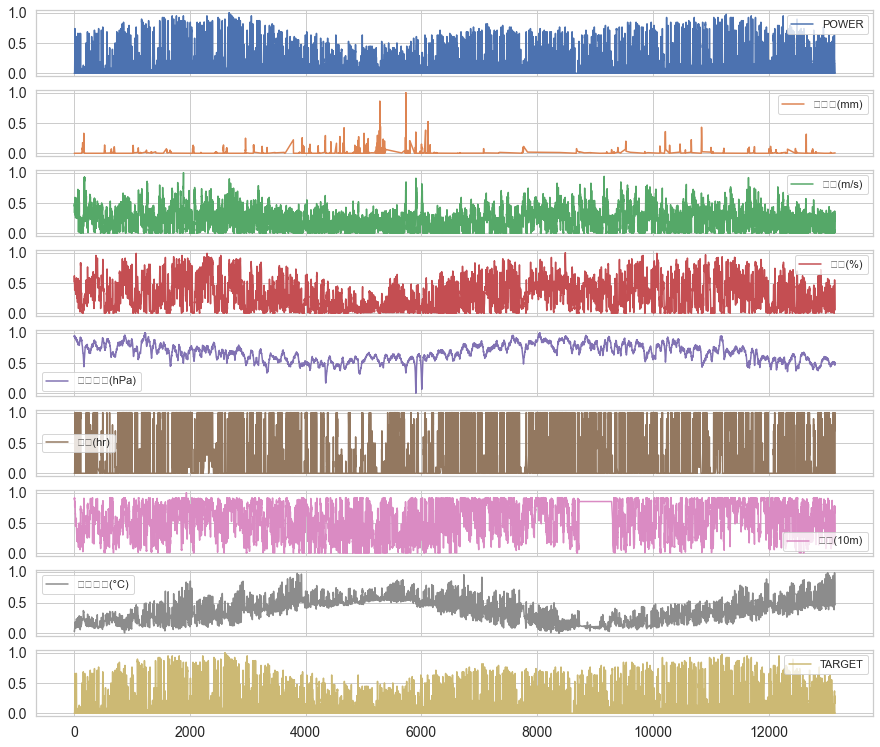

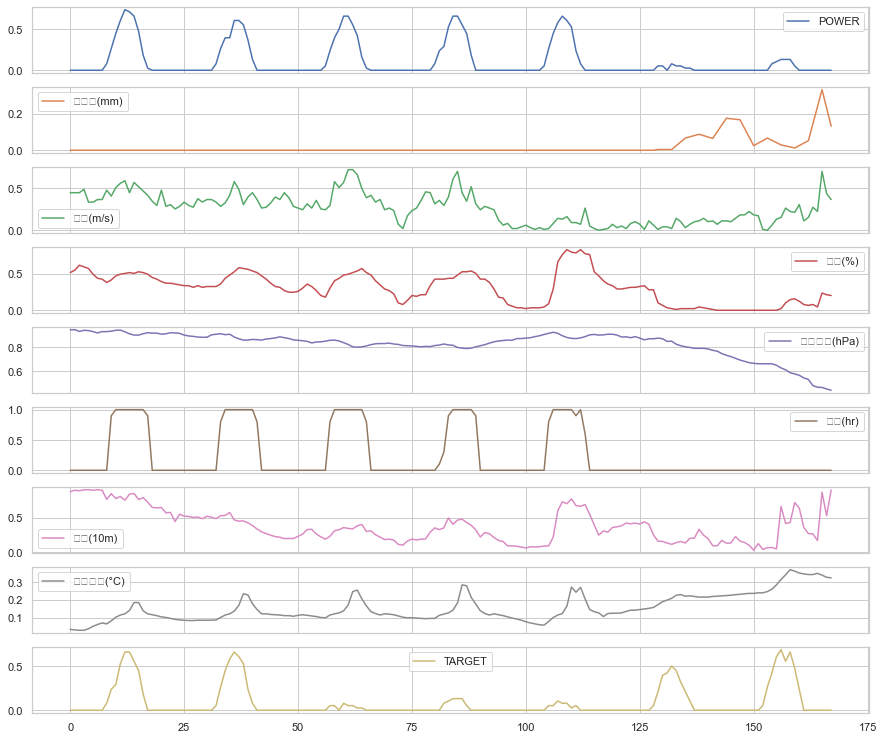

In [6]:
df.to_csv(SAVE_TOTAL_DIR + 'dataset0_'+START_DATE+'_'+END_DATE+'_TEST.csv',mode='w', index=False, encoding='CP949')

def power_process(x) :
    print('{},{}'.format(x,CAPACITY))
    if x > CAPACITY :
        print('{}>{}'.format(x,CAPACITY))
        return np.NaN
    return x

def getData():
    # 1. get dataset
    #total (power+weather)
    df = read_csv(SAVE_TOTAL_DIR + 'dataset0_'+START_DATE+'_'+END_DATE+'_TEST.csv', encoding='CP949')
    display("df:",df)
    #df = read_csv(SAVE_TOTAL_DIR + 'dataset0_'+START_DATE+'_'+END_DATE+'.csv', encoding='CP949')#, converters={'DATE':int})
    #df['POWER']=df['POWER'].apply(power_process).apply(lambda x:x)
    df[(df['POWER'] > CAPACITY)] = np.NaN #이상치 처리
    df = df.interpolate(method='linear')
    df.fillna(0, inplace=True)     #강수량
    
    # 1.1. feature selection
    #df = df[[ 'POWER', 'solarradiation', 'humidity', 'windspeed', 'windgust', 'temp', 'winddir' ]]
    # 1.2. split dataset
    #power
    df_power   = df.iloc[:, 0:1]
    #weather
    df_weather = df.copy()
    df_weather.drop(['POWER'], axis=1, inplace=True)
    display(df_weather)
    
    # 2. scale
    #power
    #df_power.drop(['DATE'], axis=1, inplace=True)
    pow_scaler = MinMaxScaler(feature_range = (0, 1))
    scaledpower = pow_scaler.fit_transform(df_power.values)
    scaledpower_df = pd.DataFrame(scaledpower, columns=df_power.columns, index=list(df_power.index.values))
    #weather
    df_weather = df_weather.copy()
    #df_weather.drop(['DATE'], axis=1, inplace=True)
    weather_scaler = MinMaxScaler(feature_range = (0, 1))#scale
    scaledweather = weather_scaler.fit_transform(df_weather.values)
    scaledweather_df = pd.DataFrame(scaledweather, columns=df_weather.columns, index=list(df_weather.index.values))

    # 3. JOIN ssss,
    #weather
    df = scaledweather_df.copy()
    #power
    df.insert(0, 'POWER', scaledpower_df.values, True)
    df = df.iloc[0:-TARGET_ILOC_STEPS, :]
    df.insert(df.shape[1], 'TARGET', scaledpower_df.iloc[TARGET_ILOC_STEPS:, :].values, True)
    df.to_csv(SAVE_TOTAL_DIR + 'dataset0_'+START_DATE+'_'+END_DATE+'_scaled.csv',mode='w',index=False, encoding='CP949')
    
    return pow_scaler, df

pow_scaler, df = getData()
display(df)
df.plot(subplots=True, figsize=(15,13), fontsize=14)
df[0:24*7].plot(subplots=True, figsize=(15,13))

In [7]:
#############################################
# create nparray
#############################################
# time step만큼 window 움직여 dataset 생성
totalsize = df.shape[0]
dataX, dataY = [], []
print("TIME_STEPS: {}, PRED_STEPS: {}".format(TIME_STEPS, PRED_STEPS))
for i in range(0, totalsize-TIME_STEPS-24+1, PRED_STEPS):
    dataX.append(df.iloc[i:(i + TIME_STEPS),0:-1])
    dataY.append(df.iloc[i:(i + PRED_STEPS),[-1]])

print("len(dataX) : ", len(dataX), dataX[0].shape)
print("len(dataY) : ", len(dataY), dataY[0].shape)

#  Split train/test 
train_size = int(len(dataX) * TRAIN_RATIO)
val_size   = int(len(dataX) * VAL_RATIO)
test_size  = len(dataX) - train_size - val_size
val_idx = train_size+val_size

trainX, valX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:val_idx]), np.array(dataX[val_idx:val_idx+test_size])
trainY, valY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:val_idx]), np.array(dataY[val_idx:val_idx+test_size])

print('train X : ', trainX.shape, '\tY : ', trainY.shape)
print('val   X : ', valX.shape,   '\tY : ', valY.shape)
print('test  X : ', testX.shape,  '\tY : ', testY.shape)

np.save(SAVE_PATH+"npset_"+SAVE_NAME+"_trainX",trainX)
np.save(SAVE_PATH+"npset_"+SAVE_NAME+"_trainY",trainY)
np.save(SAVE_PATH+"npset_"+SAVE_NAME+"_valX",valX)
np.save(SAVE_PATH+"npset_"+SAVE_NAME+"_valY",valY)
np.save(SAVE_PATH+"npset_"+SAVE_NAME+"_testX",testX)
np.save(SAVE_PATH+"npset_"+SAVE_NAME+"_testY",testY)

def show_shapes(): # can make yours to take inputs; this'll use local variable values
    print("Expected: (num_samples, TIME_STEPS, channels)")
    print("trainX:{}\t {} \t/ {}\t {}".format(trainX.dtype, trainX.shape, trainY.dtype, trainY.shape))
    print("valX:  {}\t {} \t/ {}\t {}".format(valX.dtype, valX.shape, valY.dtype, valY.shape))
    print("testX: {}\t {} \t/ {}\t {}".format(testX.dtype, testX.shape, testY.dtype, testY.shape))

show_shapes()

trainX=np.asarray(trainX).astype(np.float64)
trainY=np.asarray(trainY).astype(np.float64)
valX=np.asarray(valX).astype(np.float64)
valY=np.asarray(valY).astype(np.float64)
testX=np.asarray(testX).astype(np.float64)
testY=np.asarray(testY).astype(np.float64)

TIME_STEPS: 72, PRED_STEPS: 24
len(dataX) :  544 (72, 8)
len(dataY) :  544 (24, 1)
train X :  (326, 72, 8) 	Y :  (326, 24, 1)
val   X :  (108, 72, 8) 	Y :  (108, 24, 1)
test  X :  (110, 72, 8) 	Y :  (110, 24, 1)
Expected: (num_samples, TIME_STEPS, channels)
trainX:float64	 (326, 72, 8) 	/ float64	 (326, 24, 1)
valX:  float64	 (108, 72, 8) 	/ float64	 (108, 24, 1)
testX: float64	 (110, 72, 8) 	/ float64	 (110, 24, 1)


In [ ]:
!

In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
#############################################
# modeling
#############################################
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(256, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(tf.keras.layers.RepeatVector(PRED_STEPS))
model.add(tf.keras.layers.LSTM(256, return_sequences=True))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(256, activation='relu')))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)))
model.summary()

import pydot
import graphviz
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_layer_names=False, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

#tf.keras.utils.plot_model(model, to_file='/tmp/model_1.png', show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 256)               271360    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 24, 256)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 24, 256)           525312    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 24, 256)           65792     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 24, 1)             257       
Total params: 862,721
Trainable params: 862,721
Non-trainable params: 0
_________________________________________________________________


ModuleNotFoundError: No module named 'pydot'

In [8]:
modelList  = []
histList   = []
resultList = []
for i in range(MODEL_NUM):#0,5):#
    #keras.optimizers.RMSprop(lr=0.005, rho=0.9, epsilon=None, decay=0.0)
    
    filename = SAVE_PATH+'model_{}-checkpoint-trial{}.h5'.format(SAVE_NAME, MODEL_NUM)
    print("ModelCheckpoint filename:",filename)
    checkpoint = ModelCheckpoint(filename,             # file명을 지정합니다
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출됩니다
                             verbose=1,            # 로그를 출력합니다
                             save_best_only=True,  # 가장 best 값만 저장합니다
                             mode='auto'           # auto는 알아서 best를 찾습니다. min/max
                            )
    
    earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                                  patience=EARLY_STOP_PATIENCE,         # 10회 Epoch동안 개선되지 않는다면 종료
                                 )

    model.compile(loss='mean_squared_error', 
                    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
                    #optimizer=RMSProp()
                    #optimizer=RMSProp(learning_rate=0.001)
                    #optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True), 
                    #metrics=['acc'])
                    )

    hist = model.fit(trainX, trainY, 
                     epochs=EPOCHS, 
                     batch_size=BATCH_SIZE, 
                     validation_data=(valX, valY), 
                     callbacks=[checkpoint, earlystopping])
    
    results = model.evaluate(testX, testY)
    model.save(SAVE_PATH+'model_'+SAVE_NAME+'_'+str(i)+'.h5')# # of feature=3,5,7,9,?,12,14,16,18
    
    modelList.append(model)
    histList.append(hist)
    resultList.append(results)
    
model_best = tf.keras.models.load_model(filename)    
modelList.append(model_best)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               271360    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 24, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 256)           525312    
_________________________________________________________________
time_distributed (TimeDistri (None, 24, 256)           65792     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 24, 1)             257       
Total params: 862,721
Trainable params: 862,721
Non-trainable params: 0
_________________________________________________________________
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
ModelCheckpoint filename: C:/e

Epoch 31/500
 7/11 [==================>...........] - ETA: 0s - loss: 0.0146
Epoch 00031: val_loss did not improve from 0.01345
11/11 [==============================] - 0s 11ms/step - loss: 0.0146 - val_loss: 0.0188
Epoch 32/500
 7/11 [==================>...........] - ETA: 0s - loss: 0.0154
Epoch 00032: val_loss did not improve from 0.01345
11/11 [==============================] - 0s 11ms/step - loss: 0.0146 - val_loss: 0.0227
Epoch 33/500
 7/11 [==================>...........] - ETA: 0s - loss: 0.0149
Epoch 00033: val_loss did not improve from 0.01345
11/11 [==============================] - 0s 11ms/step - loss: 0.0144 - val_loss: 0.0218
Epoch 34/500
 7/11 [==================>...........] - ETA: 0s - loss: 0.0131
Epoch 00034: val_loss did not improve from 0.01345
11/11 [==============================] - 0s 11ms/step - loss: 0.0131 - val_loss: 0.0165
Epoch 35/500
 7/11 [==================>...........] - ETA: 0s - loss: 0.0143
Epoch 00035: val_loss did not improve from 0.01345
11/11 [=

Epoch 69/500
 7/11 [==================>...........] - ETA: 0s - loss: 0.0109
Epoch 00069: val_loss did not improve from 0.01345
11/11 [==============================] - 0s 11ms/step - loss: 0.0108 - val_loss: 0.0185
Epoch 70/500
 7/11 [==================>...........] - ETA: 0s - loss: 0.0113
Epoch 00070: val_loss did not improve from 0.01345
11/11 [==============================] - 0s 11ms/step - loss: 0.0106 - val_loss: 0.0785
Epoch 71/500
 8/11 [====================>.........] - ETA: 0s - loss: 0.0222
Epoch 00071: val_loss did not improve from 0.01345
11/11 [==============================] - 0s 10ms/step - loss: 0.0205 - val_loss: 0.0199
Epoch 72/500
 7/11 [==================>...........] - ETA: 0s - loss: 0.0120
Epoch 00072: val_loss did not improve from 0.01345
11/11 [==============================] - 0s 11ms/step - loss: 0.0123 - val_loss: 0.0235
Epoch 73/500
 7/11 [==================>...........] - ETA: 0s - loss: 0.0146
Epoch 00073: val_loss did not improve from 0.01345
11/11 [=

Epoch 107/500
 8/11 [====================>.........] - ETA: 0s - loss: 0.0088
Epoch 00107: val_loss did not improve from 0.01345
11/11 [==============================] - 0s 11ms/step - loss: 0.0083 - val_loss: 0.0293
Epoch 108/500
 7/11 [==================>...........] - ETA: 0s - loss: 0.0081
Epoch 00108: val_loss did not improve from 0.01345
11/11 [==============================] - 0s 11ms/step - loss: 0.0086 - val_loss: 0.0197
Epoch 109/500
 7/11 [==================>...........] - ETA: 0s - loss: 0.0083
Epoch 00109: val_loss did not improve from 0.01345
11/11 [==============================] - 0s 11ms/step - loss: 0.0083 - val_loss: 0.0229
Epoch 110/500
 8/11 [====================>.........] - ETA: 0s - loss: 0.0084
Epoch 00110: val_loss did not improve from 0.01345
11/11 [==============================] - 0s 11ms/step - loss: 0.0080 - val_loss: 0.0225
Epoch 111/500
 7/11 [==================>...........] - ETA: 0s - loss: 0.0082
Epoch 00111: val_loss did not improve from 0.01345
11/

Epoch 145/500
 7/11 [==================>...........] - ETA: 0s - loss: 0.0156
Epoch 00145: val_loss did not improve from 0.01345
11/11 [==============================] - 0s 11ms/step - loss: 0.0148 - val_loss: 0.0240
Epoch 146/500
 7/11 [==================>...........] - ETA: 0s - loss: 0.0147
Epoch 00146: val_loss did not improve from 0.01345
11/11 [==============================] - 0s 11ms/step - loss: 0.0145 - val_loss: 0.0190
Epoch 147/500
 7/11 [==================>...........] - ETA: 0s - loss: 0.0166
Epoch 00147: val_loss did not improve from 0.01345
11/11 [==============================] - 0s 11ms/step - loss: 0.0149 - val_loss: 0.0137
Epoch 148/500
 7/11 [==================>...........] - ETA: 0s - loss: 0.0147
Epoch 00148: val_loss did not improve from 0.01345
11/11 [==============================] - 0s 11ms/step - loss: 0.0143 - val_loss: 0.0168
Epoch 149/500
 7/11 [==================>...........] - ETA: 0s - loss: 0.0149
Epoch 00149: val_loss did not improve from 0.01345
11/

Epoch 183/500
 7/11 [==================>...........] - ETA: 0s - loss: 0.0112
Epoch 00183: val_loss did not improve from 0.01345
11/11 [==============================] - 0s 11ms/step - loss: 0.0116 - val_loss: 0.0150
Epoch 184/500
 7/11 [==================>...........] - ETA: 0s - loss: 0.0114
Epoch 00184: val_loss did not improve from 0.01345
11/11 [==============================] - 0s 11ms/step - loss: 0.0116 - val_loss: 0.0187
Epoch 185/500
 7/11 [==================>...........] - ETA: 0s - loss: 0.0109
Epoch 00185: val_loss did not improve from 0.01345
11/11 [==============================] - 0s 11ms/step - loss: 0.0115 - val_loss: 0.0167
Epoch 186/500
 7/11 [==================>...........] - ETA: 0s - loss: 0.0109
Epoch 00186: val_loss did not improve from 0.01345
11/11 [==============================] - 0s 11ms/step - loss: 0.0113 - val_loss: 0.0294
Epoch 187/500
 7/11 [==================>...........] - ETA: 0s - loss: 0.0124
Epoch 00187: val_loss did not improve from 0.01345
11/

In [9]:
print(modelList)
print(np.shape(modelList))
print(np.shape(modelList)[0])

[<tensorflow.python.keras.engine.sequential.Sequential object at 0x0000018311B1CE20>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000018314F6F1F0>]
(2,)
2


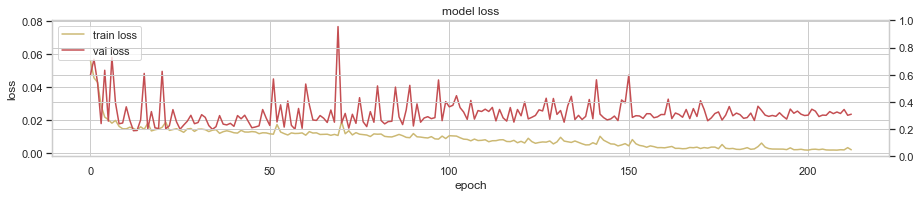

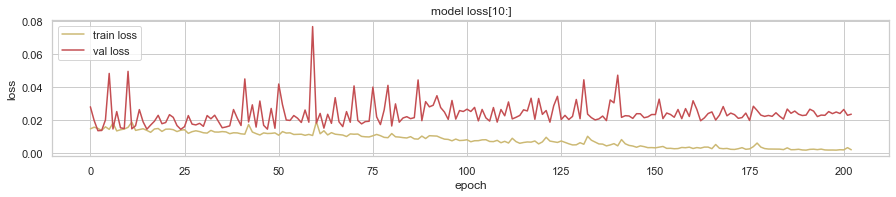

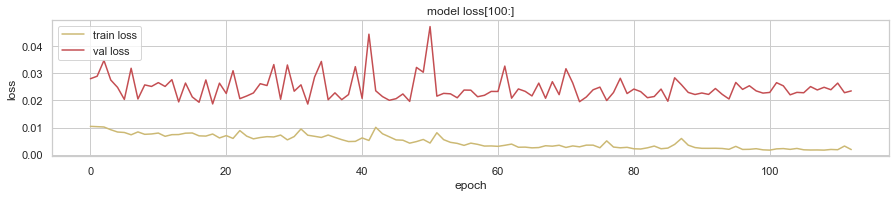

In [193]:
import matplotlib
plt.rcParams["figure.figsize"] = (15,2.5)
plt.rcParams["font.size"] = 15

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

plt.title('model loss')
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')
plt.show()

fig, loss_ax = plt.subplots()
plt.title('model loss[10:]')
loss_ax.plot(hist.history['loss'][10:], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'][10:], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')
plt.show()


fig, loss_ax = plt.subplots()
plt.title('model loss[100:]')
loss_ax.plot(hist.history['loss'][100:], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'][100:], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')
plt.show()

In [194]:
#############################################
# Prediction Error Rate
#############################################
# 예측 오차율 계산
#plt.rcParams['font.size'] = 10
predErrRate_list = []
'''modelList = []
for n in range(MODEL_NUM):
    modelList.append(load_model(SAVE_PATH+'model_'+SAVE_NAME+'_'+str(n)+'.h5'))
'''
for n in range(np.shape(modelList)[0]):
    errRate = []
    y = pow_scaler.inverse_transform(trainY[:,:,0])
    plotY = y.reshape(-1,1)

    pred = modelList[n].predict(trainX)[:,:,0]
    pred[pred<0] = 0
    x = pow_scaler.inverse_transform(pred)
    plot_pred = x.reshape(-1,1)

    target_list=[]
    for i in range(0, plotY.shape[0], PRED_STEPS):
        for hr in range(0, PRED_STEPS):
            pred   = plot_pred[i+hr]
            target = plotY[i+hr]
            difference = np.abs(target-pred)
            errRate.append(np.round(difference/CAPACITY*100, 2))

            #print("|t:",target,"-p:",pred,"|=",err,",예측오차율:",predErrRate)
            #err_list.append(err)
            
            target_list.append(target)
            
    predErrRate_list.append(errRate)
    #print(n,";",np.shape(predErrRate_list[n]))
    print("MODEL {} avg;{}".format(n,np.round(sum(predErrRate_list[n])/len(predErrRate_list[n]),4)),end='')
    print("\t max;",np.max(predErrRate_list[n]),end='')
    if (np.shape(resultList)[0]>n):
        print("\t val_loss;",np.round(resultList[n],4))
    else:
        print()
    
# save csv files    
print(np.shape(predErrRate_list))
predErrRate_df = pd.DataFrame(predErrRate_list).transpose()
predErrRate_df.to_csv(SAVE_PATH+"predErrRate_"+SAVE_NAME+".csv",mode='w',index=False, encoding='CP949')

histList_df = pd.DataFrame(histList).transpose()
histList_df.to_csv(SAVE_PATH+"histList_"+SAVE_NAME+".csv",mode='w',index=False, encoding='CP949')

resultList_df = pd.DataFrame(resultList).transpose()
resultList_df.to_csv(SAVE_PATH+"resultList_"+SAVE_NAME+".csv",mode='w',index=False, encoding='CP949')

MODEL 0 avg;[2.004]	 max; 28.38	 val_loss; 0.0241
MODEL 1 avg;[5.5849]	 max; 54.23
(2, 7824, 1)


In [195]:
####################################################### TEST
n_dataset   = testY.shape[0]
acc_list    = []
acc_model   = []
predictModel = []
predList=[]
predErrRate_list=[]
yList=[]
print(n_dataset)

print("[ model ]")
for m in range(np.shape(modelList)[0]):
    errRate=[]
    print("-"*70,"[ model {} ]".format(m))
#for m in range(2):
    plot_target=[]
    plot_predict=[]
    for i in range(n_dataset):
        #print("(dataset {}) : ".format(i), end='')
    #for i in range(5):
    #if(i in [2,3,4,5,6,7,8]): continue;
        y = pow_scaler.inverse_transform(testY[i:i+1,:,0])
        yList = y.reshape(-1,1)

        pred = modelList[m].predict([testX[i:i+1]])
        pred[pred<0] = 0
        pred = pred[:,:,0]
        pred = pow_scaler.inverse_transform(pred)
        predSum = np.sum(pred)
        predList = pred.reshape(-1,1)

        target_list=[]
        for i in range(0, yList.shape[0], PRED_STEPS):
            for hr in range(0, PRED_STEPS):
                pred   = predList[i+hr]
                target = yList[i+hr]
                difference = np.abs(target-pred)
                errRate.append(np.round(difference/CAPACITY*100, 2))
                target_list.append(target)

        target      = round(np.sum(y), 2)
        error       = round(np.abs(target-predSum), 2)
        error_rate  = np.min([round(error/target, 2),1])
        acc_rate    = round((1.0-error_rate)*100, 2)
        acc_list.append(acc_rate)
        #print("acc rate: ",np.mean(acc_list[-n_model:]),sep='')
        #predErrRateTest_AllModel.append(predErrRateTest)
        print(np.round(np.mean(acc_list[-np.shape(modelList)[0]:]),2), " / ",sep='',end='')
        
    predErrRate_list.append(errRate)
    print(" \tErr Rate avg;",np.round(sum(predErrRate_list[m])/len(predErrRate_list[m]),2),end='')
    print(" \t max;",np.max(predErrRate_list[m]))

print("\npredErrRate_list:{}".format(np.shape(predErrRate_list)))
predErrRate_df = pd.DataFrame(predErrRate_list).transpose()
predErrRate_df.to_csv(SAVE_PATH+"predErrRate_"+SAVE_NAME+"_TEST333.csv",mode='w',index=False, encoding='CP949')
print("----------------------------------------------")
print("mean(acc rate): ",np.mean(acc_list),sep='')
print("----------------------------------------------")
print("[ model ]")
#for m in range(MODEL_NUM):
    #print(predErrRateTest_AllModel[m])
    #acc_model[i] = round(acc_model[i]/(n_dataset),2)
    #print(acc_model[i])

# print Err Rate
listsize = len(predErrRate_list[0])
count = []
column_names = ["0 < x < 6","(%)","6 < x < 8","(%)","8 < x < 10","(%)", "0 < x < 10","(%)",]
for m in range(np.shape(modelList)[0]):
    testList = predErrRate_list[m].copy()
    testList.sort()
    #count = sum(map(lambda x : x>5, listOfElems))
    count.append(int(sum(map(lambda x : x<6, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    count.append(int(sum(map(lambda x : x>6 and x < 8, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    count.append(int(sum(map(lambda x : x>8 and x < 10, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    count.append(np.round(sum(map(lambda x : x < 10, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    

110
[ model ]
---------------------------------------------------------------------- [ model 0 ]
95.0 / 61.0 / 62.0 / 73.0 / 57.0 / 65.0 / 70.5 / 38.0 / 17.5 / 48.0 / 77.5 / 84.5 / 77.0 / 84.5 / 45.0 / 29.5 / 78.0 / 78.0 / 75.5 / 46.0 / 20.5 / 20.5 / 5.5 / 37.5 / 79.0 / 70.0 / 72.0 / 88.0 / 75.5 / 77.5 / 84.0 / 65.5 / 65.0 / 91.5 / 89.0 / 66.0 / 76.0 / 96.0 / 91.5 / 76.5 / 79.5 / 68.0 / 58.5 / 85.5 / 72.0 / 57.5 / 42.5 / 49.5 / 82.5 / 85.5 / 85.0 / 87.0 / 44.0 / 30.0 / 67.5 / 73.5 / 78.5 / 79.5 / 85.0 / 70.5 / 35.5 / 52.0 / 72.0 / 57.0 / 24.0 / 40.5 / 62.5 / 65.0 / 43.0 / 35.5 / 77.5 / 89.0 / 65.0 / 66.0 / 65.5 / 29.0 / 54.5 / 61.0 / 56.0 / 70.0 / 71.0 / 68.5 / 29.5 / 25.5 / 74.0 / 69.5 / 60.5 / 82.0 / 57.0 / 36.0 / 61.0 / 80.5 / 82.0 / 81.5 / 40.5 / 39.5 / 58.5 / 68.5 / 93.5 / 90.0 / 73.0 / 63.0 / 59.5 / 72.5 / 91.0 / 66.0 / 58.5 / 69.0 / 72.5 / 86.5 /  	Err Rate avg; [7.33] 	 max; 72.11
---------------------------------------------------------------------- [ model 1 ]
86.5 / 65.0 / 6

In [196]:
countArr = np.array(count).reshape(np.shape(modelList)[0],-1)
countDf = pd.DataFrame(countArr, columns = column_names)
#print(countDf)
display(countDf)
print("0 < x < 10 (%) : AVG {} \t MIN {} \t MAX {}".format(np.mean(countDf.iloc[:,-1]), np.min(countDf.iloc[:,-1]), np.max(countDf.iloc[:,-1])))
#acc_list.append(acc_rate)
#print("   pred: ",pred," | target: ",target," | error: ",error," | err rate: ",error_rate," | acc: ",acc_rate,sep="")
#print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간
print("SAVE_NAME : ", RSRS_SAVE_NM+'_'+SAVE_NAME)
print(SAVE_PATH)

<ipython-input-196-bfddd16b85ac>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  countArr = np.array(count).reshape(np.shape(modelList)[0],-1)


,0 < x < 6,(%),6 < x < 8,(%),8 < x < 10,(%),0 < x < 10,(%)
0,1705,64.58,146,5.53,109,4.13,[1962],[74.32]
1,1703,64.51,122,4.62,102,3.86,[1927],[72.99]


0 < x < 10 (%) : AVG [73.655] 	 MIN [72.99] 	 MAX [74.32]
SAVE_NAME :  249_277431_1h_500e_32b
C:/elsys/solar/data/20210720_093918_277431/


# ###########################################################

# Load model해서 예측오차율 보기

In [197]:
'''SAVE_PATH = BASE_PATH+'data/20210713_120931_696494/'
SAVE_NAME = '249_696494_1h_150e_64b'[4:]
'''

"SAVE_PATH = BASE_PATH+'data/20210713_120931_696494/'\nSAVE_NAME = '249_696494_1h_150e_64b'[4:]\n"

In [198]:
'''modelList = []
print(SAVE_PATH)
for m in range(np.shape(modelList)[0]):
    modelList.append(load_model(SAVE_PATH+'model_'+SAVE_NAME+'_'+str(m)+'.h5'))
''' 
X_train = np.load(SAVE_PATH+"npset_"+SAVE_NAME+"_trainX.npy")
y_train = np.load(SAVE_PATH+"npset_"+SAVE_NAME+"_trainY.npy")
X_test  = np.load(SAVE_PATH+"npset_"+SAVE_NAME+"_testX.npy")
y_test  = np.load(SAVE_PATH+"npset_"+SAVE_NAME+"_testY.npy")

print("X_test : ", X_test.shape)
print("y_test : ", y_test.shape)

X_test :  (110, 72, 8)
y_test :  (110, 24, 1)


# train _err rate

In [199]:
predErrRate_list = []
'''modelList = []
for n in range(np.shape(modelList)[0]):
    modelList.append(load_model(SAVE_PATH+'model_'+SAVE_NAME+'_'+str(n)+'.h5'))
'''
    
for n in range(np.shape(modelList)[0]):
    errRate = []
    y = pow_scaler.inverse_transform(y_train[:,:,0])
    plotY = y.reshape(-1,1)

    pred = modelList[n].predict(X_train)[:,:,0]
    pred[pred<0] = 0
    x = pow_scaler.inverse_transform(pred)
    plot_pred = x.reshape(-1,1)

    target_list=[]
    for i in range(0, plotY.shape[0], PRED_STEPS):
        for hr in range(0, PRED_STEPS):
            pred   = plot_pred[i+hr]
            target = plotY[i+hr]
            difference = np.abs(target-pred)
            errRate.append(np.round(difference/CAPACITY*100, 2))
            target_list.append(target)
            
    predErrRate_list.append(errRate)
    print(n," avg;",np.round(sum(predErrRate_list[n])/len(predErrRate_list[n]),2),end='')
    print(" \t max;",np.max(predErrRate_list[n]))    
# save csv files    
print(np.shape(predErrRate_list))
predErrRate_df = pd.DataFrame(predErrRate_list).transpose()
print("SAVE_NAME : ", SAVE_NAME)

listsize = len(predErrRate_list[0])
count = []
column_names = ["0 < x < 6","(%)","6 < x < 8","(%)","8 < x < 10","(%)", "0 < x < 10","(%)",]
for m in range(np.shape(modelList)[0]):
    testList = predErrRate_list[m].copy()
    testList.sort()
    #count = sum(map(lambda x : x>5, listOfElems))
    count.append(int(sum(map(lambda x : x<6, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    count.append(int(sum(map(lambda x : x>6 and x < 8, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    count.append(int(sum(map(lambda x : x>8 and x < 10, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    count.append(np.round(sum(map(lambda x : x < 10, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    
countArr = np.array(count).reshape(np.shape(modelList)[0],-1)
countDf = pd.DataFrame(countArr, columns = column_names)
display(countDf)

0  avg; [2.] 	 max; 28.38
1  avg; [5.58] 	 max; 54.23
(2, 7824, 1)
SAVE_NAME :  277431_1h_500e_32b


<ipython-input-199-e2ed3c352504>:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  countArr = np.array(count).reshape(np.shape(modelList)[0],-1)


,0 < x < 6,(%),6 < x < 8,(%),8 < x < 10,(%),0 < x < 10,(%)
0,7173,91.68,311,3.97,149,1.9,[7637],[97.61]
1,5457,69.75,373,4.77,315,4.03,[6152],[78.63]


TrainY: 326.0 일 ( 7824 시간)


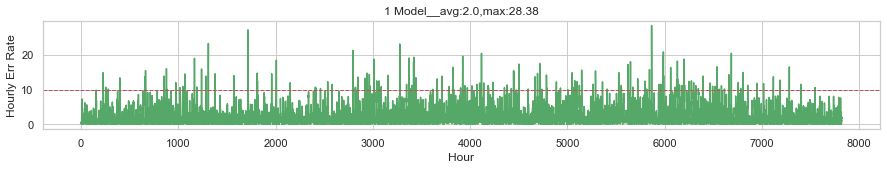

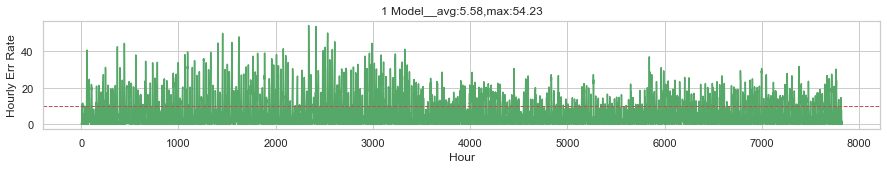

In [200]:
HOUR_STEPS = 24
print("TrainY:",np.rint(np.shape(predErrRate_list[n])[0]/HOUR_STEPS),"일 (", np.shape(predErrRate_list[n])[0],"시간)")

for n in range(np.shape(modelList)[0]):
    #print("[ {} MODEL ] mean:{}, max:{}".format(n, np.round(np.mean(predErrRate_list[n]),3), np.max(predErrRate_list[n])))
    mean = np.round(np.mean(predErrRate_list[n]), 2)
    max  = np.round(np.max(predErrRate_list[n]), 2)
    
    #plotAcc = np.array(acc_list).reshape(-1,1)
    plt.rcParams["figure.figsize"] = (15,2)
    #plt.title("Hourly Err Rate(TrainY)")
    plt.title(str(m)+" Model__avg:"+str(mean)+",max:"+str(max))
    plt.xlabel('Hour')
    plt.ylabel('Hourly Err Rate')
    #plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
    #plt.ylim(0,10)
    plt.plot(predErrRate_list[n], 'g-')
    plt.axhline(y=10, color='r',linestyle='--', linewidth=1)
    plt.grid(True)
    plt.show()
    #print(predErrRate_list)

TrainY: 326.0 일 ( 7824 시간)


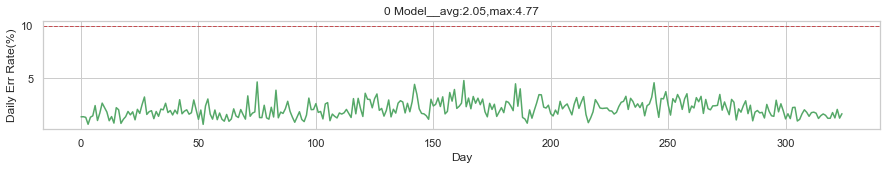

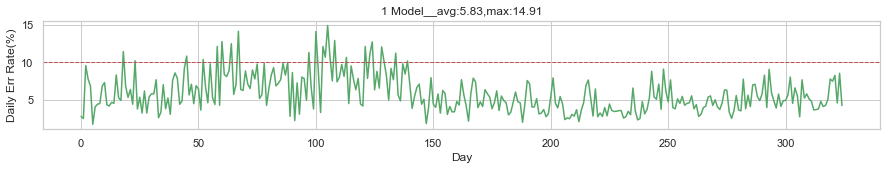

In [201]:
HOUR_STEPS = 24
print("TrainY:",np.rint(np.shape(predErrRate_list[n])[0]/HOUR_STEPS),"일 (", np.shape(predErrRate_list[n])[0],"시간)")

for m in range(np.shape(modelList)[0]):
    dailyErrRate = []
    for i in range(0, plotY.shape[0]-HOUR_STEPS, HOUR_STEPS):
        dailyErrRate.append(np.mean(predErrRate_list[m][i:i+HOUR_STEPS-1]))
    mean = np.round(np.mean(dailyErrRate), 2)
    max  = np.round(np.max(dailyErrRate), 2)
    
    #plotAcc = np.array(acc_list).reshape(-1,1)
    plt.rcParams['font.size'] = 10
    plt.rcParams["figure.figsize"] = (15,2)
    plt.title(str(m)+" Model__avg:"+str(mean)+",max:"+str(max))
    plt.xlabel('Day')
    plt.ylabel('Daily Err Rate(%)')
    #plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
    #plt.ylim(0,10)
    plt.plot(dailyErrRate, 'g-')
    plt.axhline(y=10, color='r',linestyle='--', linewidth=1)
    plt.grid(True)
    plt.show()

# TEST _err rate

In [202]:
n_dataset   = y_test.shape[0]
acc_list    = []
acc_model   = []
predictModel = []
predList=[]
predErrRate_list=[]
yList=[]
print(n_dataset)

print("[ model ]")
for m in range(np.shape(modelList)[0]):
    errRate=[]
    print("-"*70,"[ model {} ]".format(m))
#for m in range(2):
    plot_target=[]
    plot_predict=[]
    for i in range(n_dataset):
        #print("(dataset {}) : ".format(i), end='')
    #for i in range(5):
    #if(i in [2,3,4,5,6,7,8]): continue;
        y = pow_scaler.inverse_transform(y_test[i:i+1,:,0])
        yList = y.reshape(-1,1)

        pred = modelList[m].predict([X_test[i:i+1]])
        pred[pred<0] = 0
        pred = pred[:,:,0]
        pred = pow_scaler.inverse_transform(pred)
        predSum = np.sum(pred)
        predList = pred.reshape(-1,1)

        target_list=[]
        for i in range(0, yList.shape[0], PRED_STEPS):
            for hr in range(0, PRED_STEPS):
                pred   = predList[i+hr]
                target = yList[i+hr]
                difference = np.abs(target-pred)
                errRate.append(np.round(difference/CAPACITY*100, 2))
                target_list.append(target)

        target      = round(np.sum(y), 2)
        error       = round(np.abs(target-predSum), 2)
        error_rate  = np.min([round(error/target, 2),1])
        acc_rate    = round((1.0-error_rate)*100, 2)
        acc_list.append(acc_rate)
        #print("acc rate: ",np.mean(acc_list[-n_model:]),sep='')
        #predErrRateTest_AllModel.append(predErrRateTest)
        print(np.round(np.mean(acc_list[-np.shape(modelList)[0]:]),2), " / ",sep='',end='')
        
    predErrRate_list.append(errRate)
    print(" \tErr Rate avg;",np.round(sum(predErrRate_list[m])/len(predErrRate_list[m]),2),end='')
    print(" \t max;",np.max(predErrRate_list[m]))

print("\npredErrRate_list:{}".format(np.shape(predErrRate_list)))
predErrRate_df = pd.DataFrame(predErrRate_list).transpose()
#predErrRate_df.to_csv(SAVE_PATH+"predErrRate_"+SAVE_NAME+"_TEST333.csv",mode='w',index=False, encoding='CP949')
print("----------------------------------------------")
print("mean(acc rate): ",np.mean(acc_list),sep='')
print("----------------------------------------------")
print("[ model ]")
#for m in range(MODEL_NUM):
    #print(predErrRateTest_AllModel[m])
    #acc_model[i] = round(acc_model[i]/(n_dataset),2)
    #print(acc_model[i])

110
[ model ]
---------------------------------------------------------------------- [ model 0 ]
95.0 / 61.0 / 62.0 / 73.0 / 57.0 / 65.0 / 70.5 / 38.0 / 17.5 / 48.0 / 77.5 / 84.5 / 77.0 / 84.5 / 45.0 / 29.5 / 78.0 / 78.0 / 75.5 / 46.0 / 20.5 / 20.5 / 5.5 / 37.5 / 79.0 / 70.0 / 72.0 / 88.0 / 75.5 / 77.5 / 84.0 / 65.5 / 65.0 / 91.5 / 89.0 / 66.0 / 76.0 / 96.0 / 91.5 / 76.5 / 79.5 / 68.0 / 58.5 / 85.5 / 72.0 / 57.5 / 42.5 / 49.5 / 82.5 / 85.5 / 85.0 / 87.0 / 44.0 / 30.0 / 67.5 / 73.5 / 78.5 / 79.5 / 85.0 / 70.5 / 35.5 / 52.0 / 72.0 / 57.0 / 24.0 / 40.5 / 62.5 / 65.0 / 43.0 / 35.5 / 77.5 / 89.0 / 65.0 / 66.0 / 65.5 / 29.0 / 54.5 / 61.0 / 56.0 / 70.0 / 71.0 / 68.5 / 29.5 / 25.5 / 74.0 / 69.5 / 60.5 / 82.0 / 57.0 / 36.0 / 61.0 / 80.5 / 82.0 / 81.5 / 40.5 / 39.5 / 58.5 / 68.5 / 93.5 / 90.0 / 73.0 / 63.0 / 59.5 / 72.5 / 91.0 / 66.0 / 58.5 / 69.0 / 72.5 / 86.5 /  	Err Rate avg; [7.33] 	 max; 72.11
---------------------------------------------------------------------- [ model 1 ]
86.5 / 65.0 / 6

In [203]:
listsize = len(predErrRate_list[0])
count = []
column_names = ["0 < x < 6","(%)","6 < x < 8","(%)","8 < x < 10","(%)", "0 < x < 10","(%)",]
for m in range(np.shape(modelList)[0]):
    testList = predErrRate_list[m].copy()
    testList.sort()
    #count = sum(map(lambda x : x>5, listOfElems))
    count.append(int(sum(map(lambda x : x<6, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    count.append(int(sum(map(lambda x : x>6 and x < 8, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    count.append(int(sum(map(lambda x : x>8 and x < 10, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    count.append(np.round(sum(map(lambda x : x < 10, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    
countArr = np.array(count).reshape(np.shape(modelList)[0],-1)
countDf = pd.DataFrame(countArr, columns = column_names)
display(countDf)

print("0 < x < 10 (%) : AVG {} \t MIN {} \t MAX {}".format(np.mean(countDf.iloc[:,-1]), np.min(countDf.iloc[:,-1]), np.max(countDf.iloc[:,-1])))
#count2 = getCount(testList, lambda x : x>5 and x < 20)
#print("{} Model :\t{} \t({}%) \t{} \t({}%) \t{} \t({}%)  \t{} \t({}%)".format(m, int(count1), float(np.round(count1/listsize*100,2)),int(count2), float(np.round(count2/listsize*100,2)),int(count3), float(np.round(count3/listsize*100,2)),int(count4), float(np.round(count4/listsize*100,2))))

<ipython-input-203-bc07d8f26522>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  countArr = np.array(count).reshape(np.shape(modelList)[0],-1)


,0 < x < 6,(%),6 < x < 8,(%),8 < x < 10,(%),0 < x < 10,(%)
0,1705,64.58,146,5.53,109,4.13,[1962],[74.32]
1,1703,64.51,122,4.62,102,3.86,[1927],[72.99]


0 < x < 10 (%) : AVG [73.655] 	 MIN [72.99] 	 MAX [74.32]


TrainY: 110.0 일 ( 2640 시간)


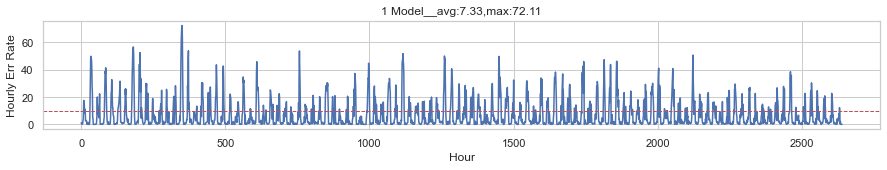

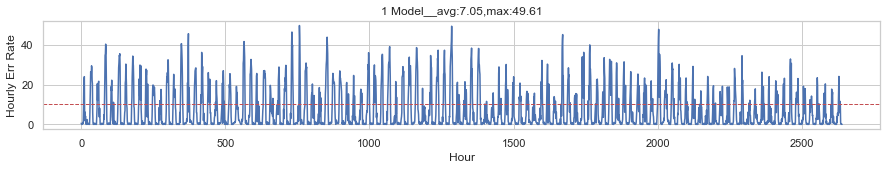

In [204]:
HOUR_STEPS = 24
print("TrainY:",np.rint(np.shape(predErrRate_list[n])[0]/HOUR_STEPS),"일 (", np.shape(predErrRate_list[n])[0],"시간)")

for n in range(np.shape(modelList)[0]):
    #print("[ {} MODEL ] mean:{}, max:{}".format(n, np.round(np.mean(predErrRate_list[n]),3), np.max(predErrRate_list[n])))
    mean = np.round(np.mean(predErrRate_list[n]), 2)
    max  = np.round(np.max(predErrRate_list[n]), 2)
    
    #plotAcc = np.array(acc_list).reshape(-1,1)
    plt.rcParams["figure.figsize"] = (15,2)
    #plt.title("Hourly Err Rate(TrainY)")
    plt.title(str(m)+" Model__avg:"+str(mean)+",max:"+str(max))
    plt.xlabel('Hour')
    plt.ylabel('Hourly Err Rate')
    #plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
    #plt.ylim(0,10)
    plt.plot(predErrRate_list[n], 'b-')
    plt.axhline(y=10, color='r',linestyle='--', linewidth=1)
    plt.grid(True)
    plt.show()
    #print(predErrRate_list)

TrainY: 110.0 일 ( 2640 시간)


c:\users\vislab_phy\anaconda3\envs\py_38_shap\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\vislab_phy\anaconda3\envs\py_38_shap\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


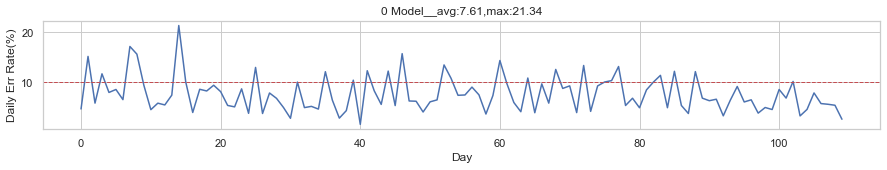

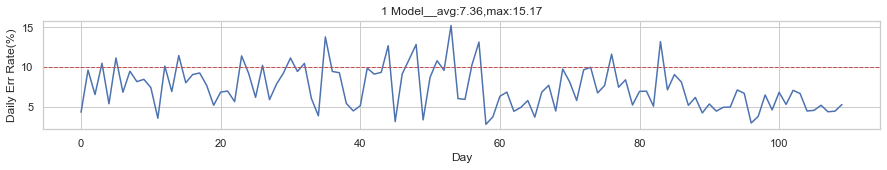

In [205]:
HOUR_STEPS = 24
print("TrainY:",np.rint(np.shape(predErrRate_list[n])[0]/HOUR_STEPS),"일 (", np.shape(predErrRate_list[n])[0],"시간)")

for m in range(np.shape(modelList)[0]):
    dailyErrRate = []
    for i in range(0, plotY.shape[0]-HOUR_STEPS, HOUR_STEPS):
        dailyErrRate.append(np.mean(predErrRate_list[m][i:i+HOUR_STEPS-1]))
        
    dailyErrRate = [x for x in dailyErrRate if np.isnan(x) == False]
    mean = np.round(np.mean(dailyErrRate), 2)
    max  = np.round(np.max(dailyErrRate), 2)
    
    #plotAcc = np.array(acc_list).reshape(-1,1)
    plt.rcParams['font.size'] = 10
    plt.rcParams["figure.figsize"] = (15,2)
    plt.title(str(m)+" Model__avg:"+str(mean)+",max:"+str(max))
    plt.xlabel('Day')
    plt.ylabel('Daily Err Rate(%)')
    #plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
    #plt.ylim(0,10)
    plt.plot(dailyErrRate, 'b-')
    plt.axhline(y=10, color='r',linestyle='--', linewidth=1)
    plt.grid(True)
    plt.show()

In [206]:
plt.rcParams['font.size'] = 40
y = pow_scaler.inverse_transform(y_test[:,:,0])
plotY = y.reshape(-1,1)
print("step: ",plotY.shape[0])
print(int(plotY.shape[0]/HOUR_STEPS))

step:  2640
110


,0 < x < 6,(%),6 < x < 8,(%),8 < x < 10,(%),0 < x < 10,(%)
0,1705,64.58,146,5.53,109,4.13,[1962],[74.32]
1,1703,64.51,122,4.62,102,3.86,[1927],[72.99]


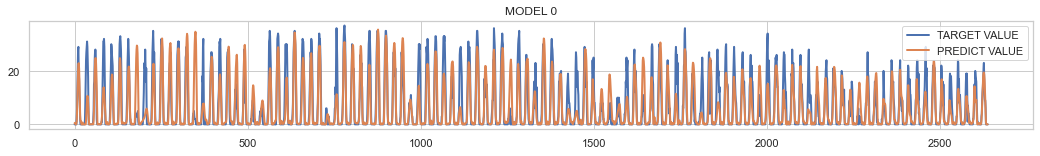

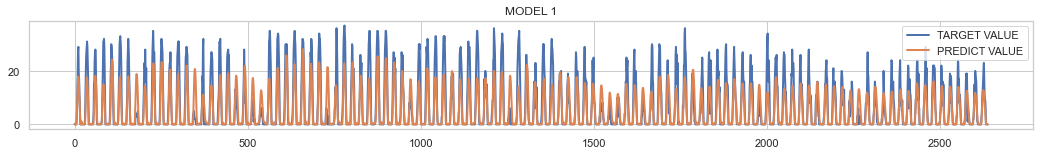

In [207]:
#y = pow_scaler.inverse_transform(y_test[:,:,0])
plotY = y.reshape(-1,1)
step = int(plotY.shape[0])
display(countDf)
for m in range(np.shape(modelList)[0]):
    pred = modelList[m].predict(X_test)[:,:,0]
    pred[pred<0] = 0

    x = pow_scaler.inverse_transform(pred)
    plotY_pred = x.reshape(-1,1)

    acc_list = []
    target_list=[]

    for i in range(0, plotY.shape[0]-step+1, step):
        plt.rcParams["figure.figsize"] = (18,2)
        plt.rcParams["font.size"] = 15
        plt.title("MODEL "+str(m))
        plt.plot(plotY[i:i+step], label="TARGET VALUE",linewidth=2)#,linewidth=4, alpha=0.7)
        plt.plot(plotY_pred[i:i+step],label="PREDICT VALUE",linewidth=2)#,linewidth=2, alpha=1)
        plt.grid(True)
        plt.legend()
        plt.show()

0, 2640-360+1, 360


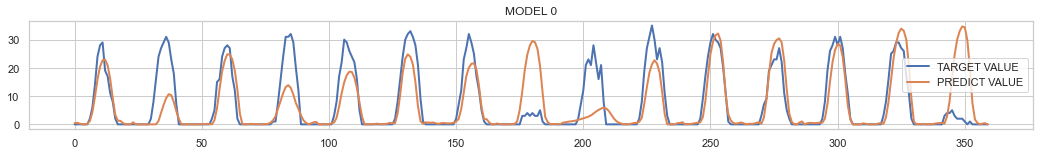

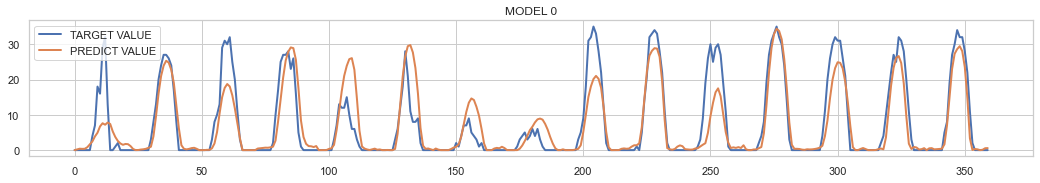

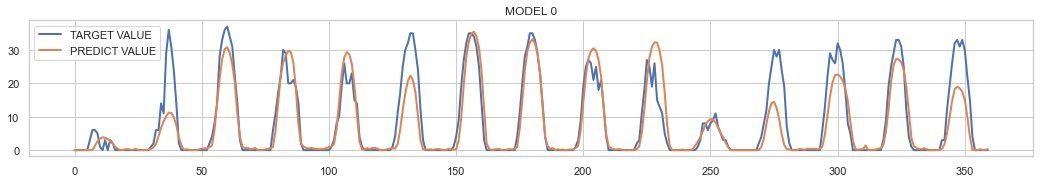

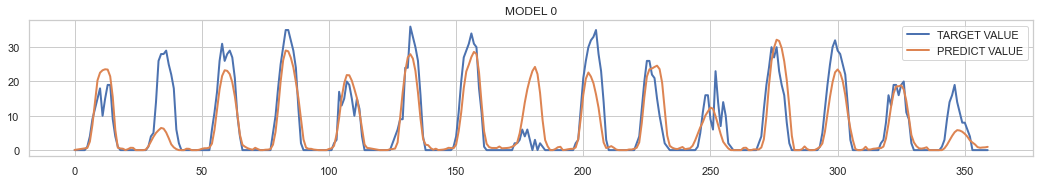

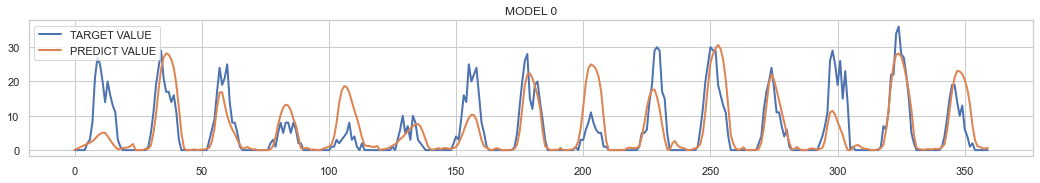

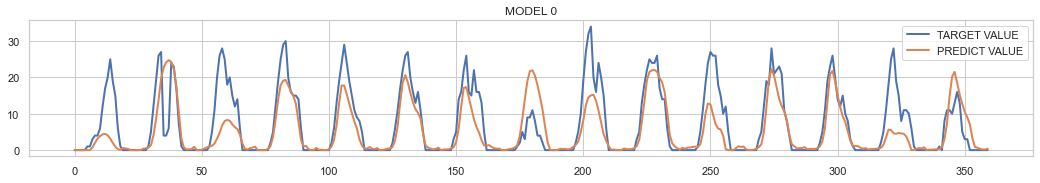

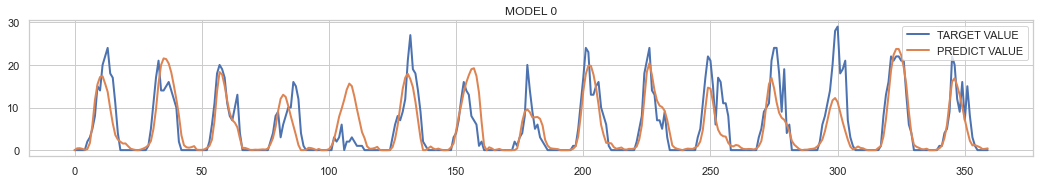

0, 2640-360+1, 360


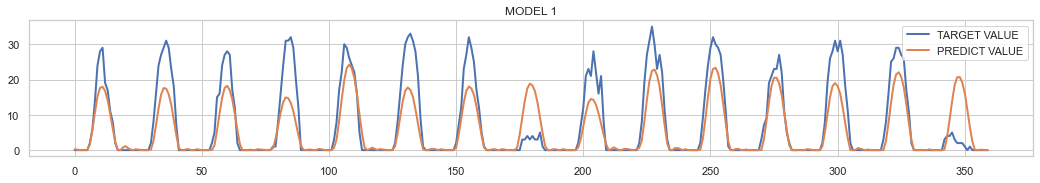

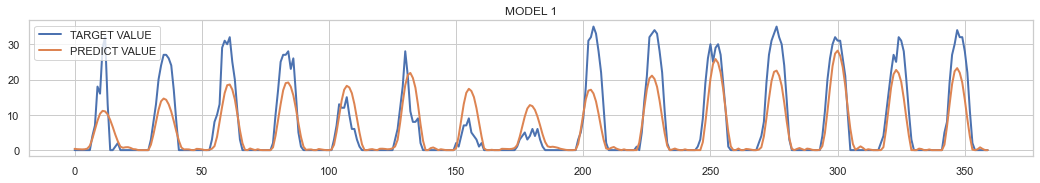

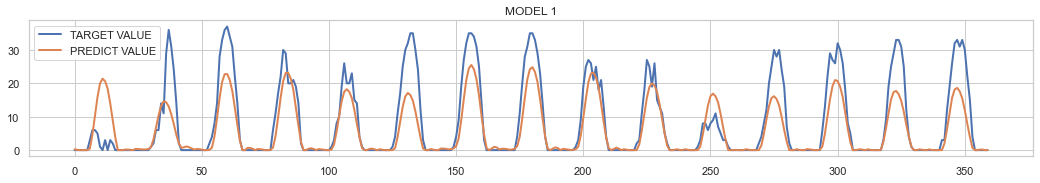

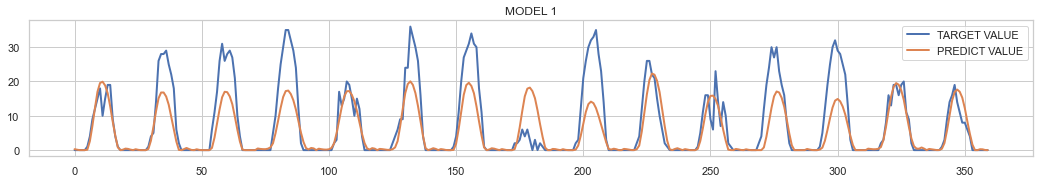

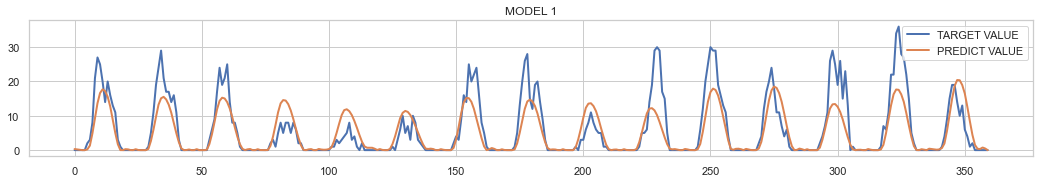

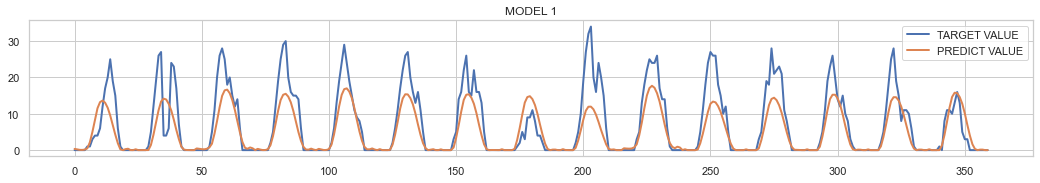

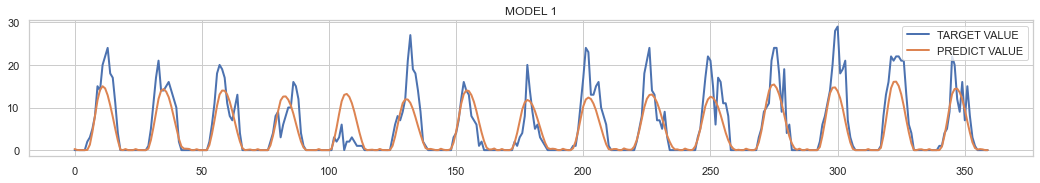

In [208]:
y = pow_scaler.inverse_transform(y_test[:,:,0])
plotY = y.reshape(-1,1)
step = int(plotY.shape[0])

for m in range(np.shape(modelList)[0]):
    pred = modelList[m].predict(X_test)[:,:,0]
    pred[pred<0] = 0

    x = pow_scaler.inverse_transform(pred)
    plotY_pred = x.reshape(-1,1)

    acc_list = []
    target_list=[]
    
    step = PRED_STEPS*15 #timesteps#
    print("0, {}-{}+1, {}".format(plotY.shape[0],step,step))
    for i in range(0, plotY.shape[0]-step+1, step):
        plt.title("MODEL "+str(m))
        plt.rcParams["figure.figsize"] = (18,2.5)
        plt.plot(plotY[i:i+step], label="TARGET VALUE",linewidth=2)#,linewidth=4, alpha=0.7)
        plt.plot(plotY_pred[i:i+step],label="PREDICT VALUE",linewidth=2)#,linewidth=2, alpha=1)
        plt.grid(True)
        plt.legend()
        plt.show()

trainY:  7824 - 360


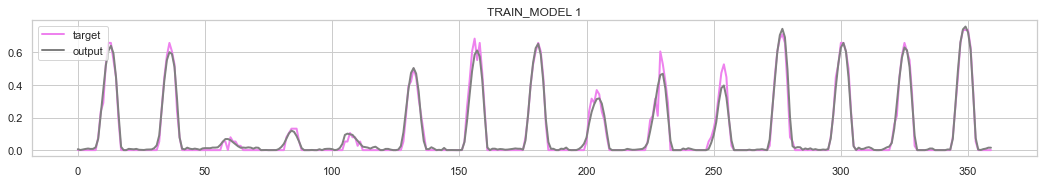

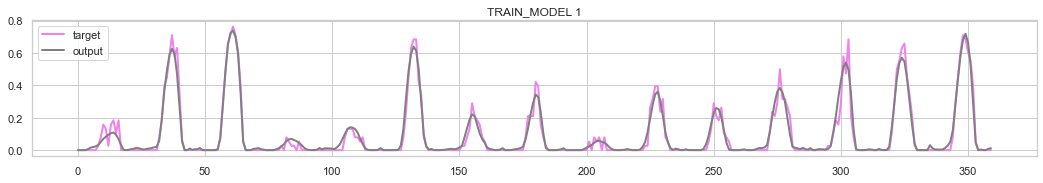

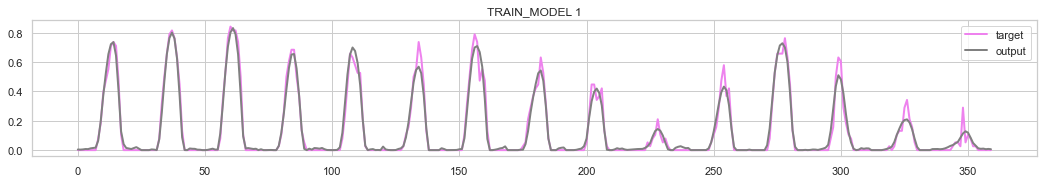

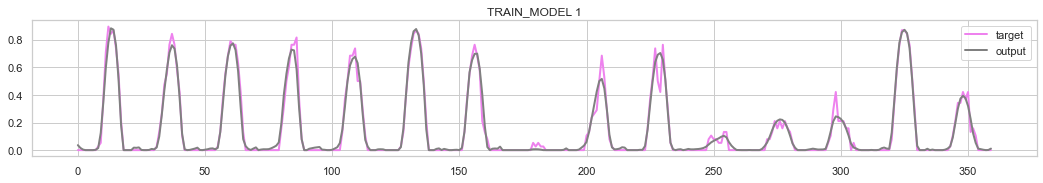

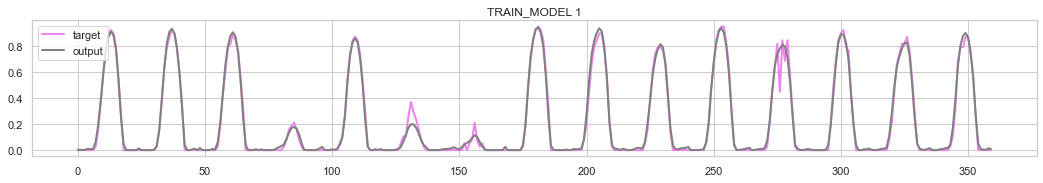

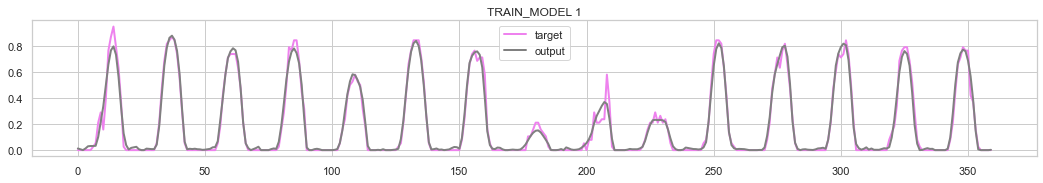

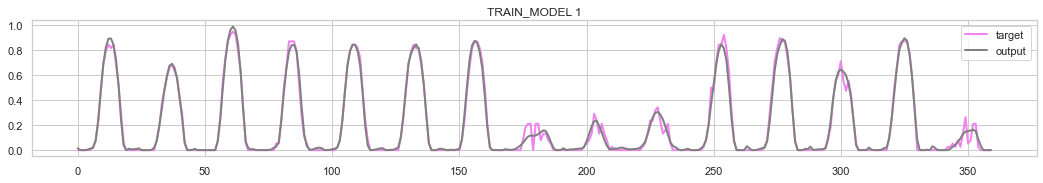

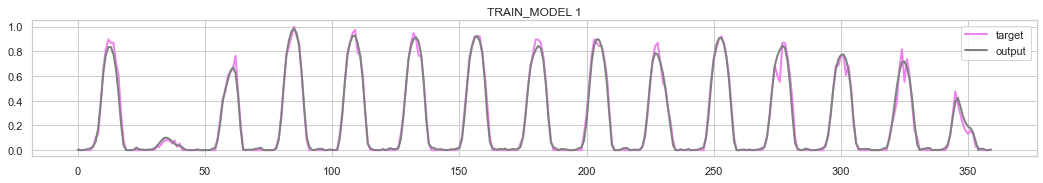

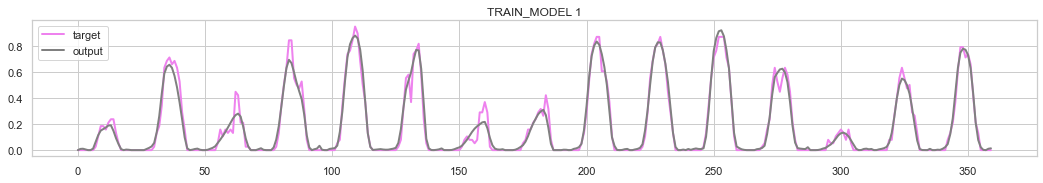

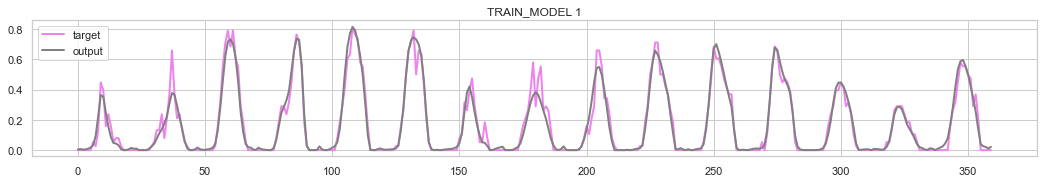

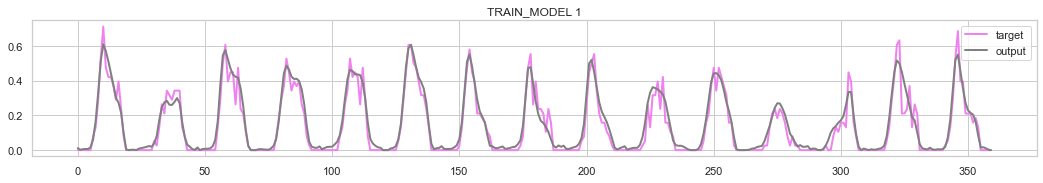

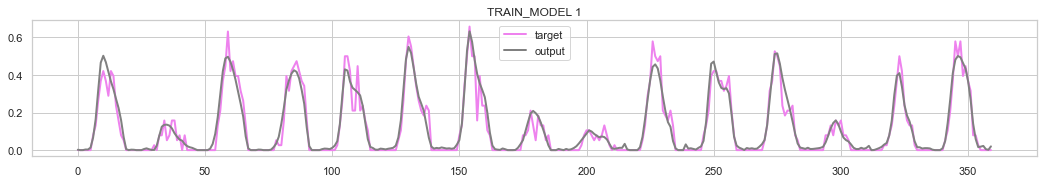

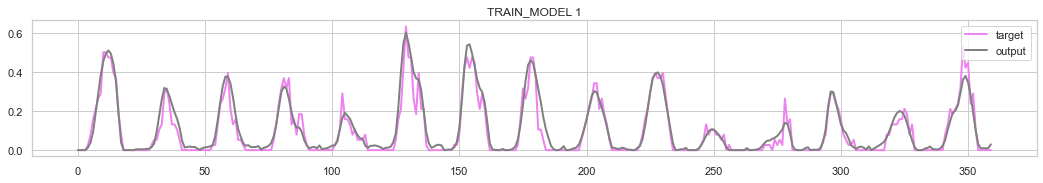

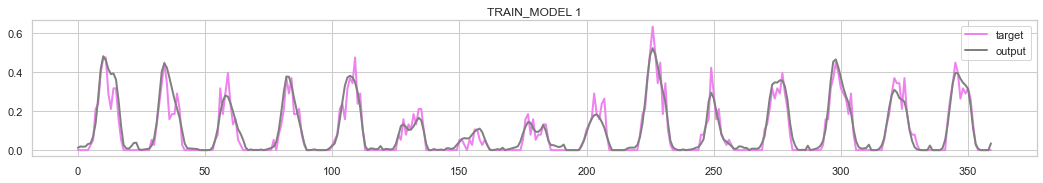

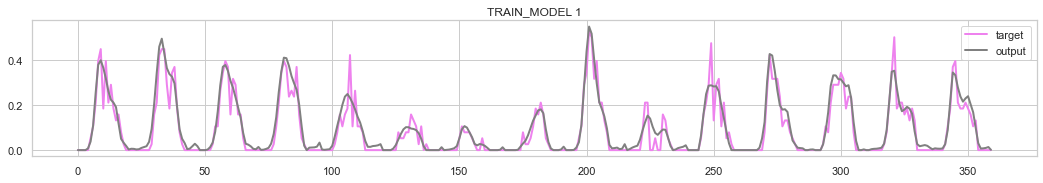

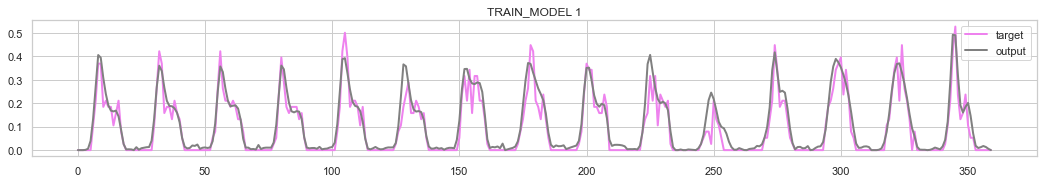

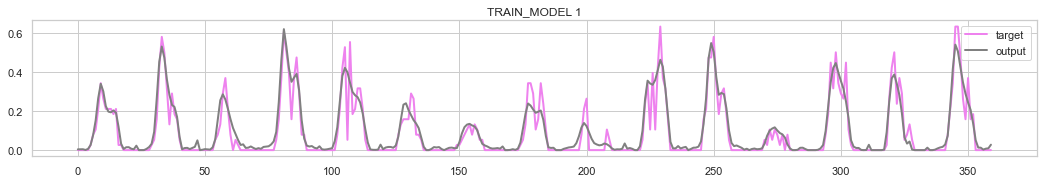

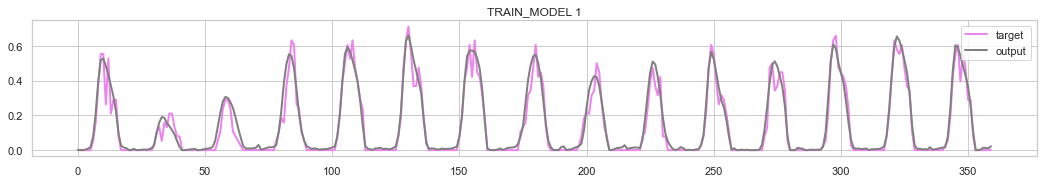

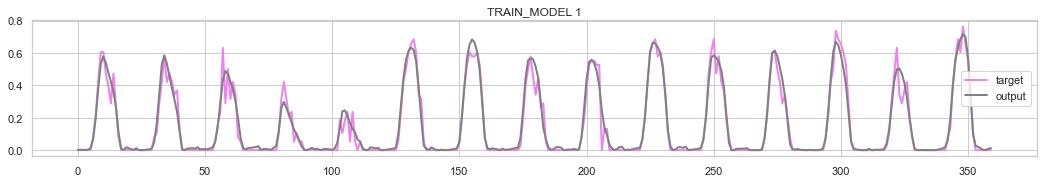

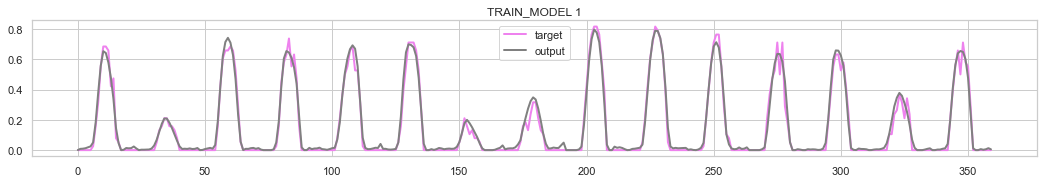

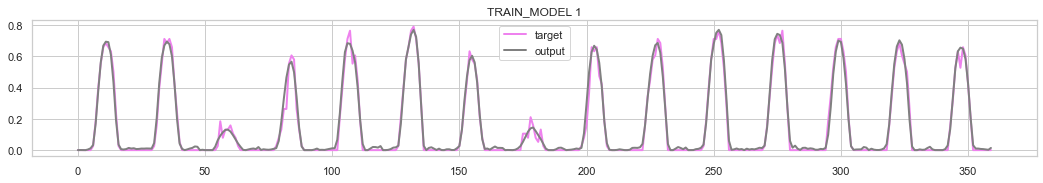

In [209]:
plotY = trainY.reshape(-1,1)
plotY_pred = model.predict(trainX).reshape(-1,1)
plotY_pred[plotY_pred<0] = 0

step = PRED_STEPS*15 #timesteps#
print('trainY: ',plotY.shape[0],'-',step)
for i in range(0, plotY.shape[0]-step, step):
    plt.title("TRAIN_MODEL "+str(m))
    plt.rcParams["figure.figsize"] = (18,2.5)
    plt.plot(plotY[i:i+step], label="target",linewidth=2, alpha=1, color='violet')
    plt.plot(plotY_pred[i:i+step], label="output",linewidth=2, alpha=1, color='grey')
    #plt.plot(plotY[i:i+step], 'r-', label="target",linewidth=2, alpha=1)
    #plt.plot(plotY_pred[i:i+step], 'y-', label="output",linewidth=2, alpha=1)
    plt.grid(True)
    plt.legend()
    plt.show()


# 여기 위에까지~

# Test dataset